In [1]:
import pandas as pd 
import numpy as np 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from src.files.fasta import FASTAFile
from Bio import Phylo
from itertools import product, combinations
from utils import *
from src.coevolution import get_scores
from scipy.stats import mannwhitneyu
from src.files.itol import *
import io
from src.tree import *  

%load_ext autoreload 
%autoreload 2

is_homogenous = lambda df : df.category.nunique() == 1

In [132]:
# Want to compare the regions where the divergence scores are highest. Would expect to see higher divergence scores around
# the N-terminus when comparing Pyl+ vs. Pyl-. Probably should control for evolutionary distance, i.e. compare clades which are similarly
# distant. Probably the easiest way to do this is by clustering the release factors and then building a tree of the representatives. 

arf1_df = pd.read_csv('../data/arf1_cleaned.csv', index_col=0)
# build_stop_codon_genome_metadata_dataset(arf1_df.genome_id.unique())
stop_codon_genome_metadata_df = pd.read_csv('../data/arf1_stop_codon_metadata.csv', index_col=0)

arf1_df['tag_count'] = arf1_df.genome_id.map(stop_codon_genome_metadata_df.groupby('genome_id').TAG.first())
arf1_df['stop_codon_count'] = arf1_df.genome_id.map(stop_codon_genome_metadata_df.groupby('genome_id')['total'].first())
arf1_df['tag_percent'] = arf1_df.tag_count / arf1_df.stop_codon_count


# I think more granular categories could be helpful:
# (1) Pyl+ and largely re-coded (TAG < 5%)
# (2) Pyl+ which still use lots of TAG stops (TAG > 5%) 
# (3) Pyl- (including the weird outliers

masks = dict()
masks['pyl+'] = (arf1_df.tag_percent < 0.05) & (arf1_df.has_pyl)
masks['pyl-'] = (~arf1_df.has_pyl)

categories = list(masks.keys())
arf1_df['category'] = np.select([masks[category] for category in categories], categories, default='none')
print('Num. sequences being discarded which are not in either Pyl+ recoded or Pyl- categories:', (arf1_df.category == 'none').sum())
arf1_df = arf1_df[arf1_df.category != 'none'].copy()

Num. sequences being discarded which are not in either Pyl+ recoded or Pyl- categories: 73


In [3]:
# I think the clustering approach from sandbox-1 is flawed, because it is pretty clear that aRF1 similarity might not track phylogeny. 
# By clustering by aRF1 similarity, I am kind of defeating the purpose of controlling for phylogeny in the comparisons. I think 
# instead of clustering, it might make more sense to count the number of significant mutations between similarly-related organisms
# in different categories. 

In [130]:
def get_distances(arf1_df, tree, max_distance=2.5):

    arf1_df = arf1_df.copy()
    arf1_df['protein_id'] = arf1_df.index 
    arf1_df = arf1_df.set_index('genome_id') # Need to use the genome ID as an index to work with the tree. 

    # Precompute the distances to the roots. 
    leaves = [tree.find_any(genome_id) for genome_id in arf1_df.index]
    distances_to_root = {leaf:tree.distance(tree.root, leaf) for leaf in leaves} # Can use the clade objects themselves as keys. 

    distance_df = list()

    for leaf_1, leaf_2 in tqdm(list(combinations(leaves, 2)), desc='get_distances'):
        genome_id_1, genome_id_2 = leaf_1.name, leaf_2.name 
        row = {'genome_id_1':leaf_1.name, 'genome_id_2':leaf_2.name}

        lca = tree.common_ancestor(leaf_1, leaf_2) # Using the LCA to get distance is *much* faster (thanks ChatGPT)... should look into why. 
        lca_distance_to_root = distances_to_root.get(lca, tree.distance(tree.root, lca)) # Only compute the distance if it's not already in the dictionary. 
        distances_to_root[lca] = lca_distance_to_root # Store in the lookup table. 
        distance = distances_to_root[leaf_1] + distances_to_root[leaf_2] - (2 * lca_distance_to_root)

        if distance < max_distance:
            row['distance'] = distance 
            row['category_1'], row['category_2'] = arf1_df.loc[genome_id_1].category, arf1_df.loc[genome_id_2].category
            row['protein_id_1'], row['protein_id_2'] = arf1_df.loc[genome_id_1].protein_id, arf1_df.loc[genome_id_2].protein_id
            row['category'] = ' vs. '.join(sorted([row['category_1'], row['category_2']]))
            distance_df.append(row) # Only add if the distance is not too far. 

    distance_df = pd.DataFrame(distance_df)
    return distance_df

tree = gtdb_load_ar53_tree(genome_ids=arf1_df.genome_id.unique())

if not os.path.exists('../data/arf1_tree_distances_ar53.csv'):
    distance_df = get_distances(arf1_df, tree)
    distance_df.to_csv('../data/arf1_tree_distances_ar53.csv')
distance_df = pd.read_csv('../data/arf1_tree_distances_ar53.csv', index_col=0)

# Don't want to include this genome in the analysis in case it skews things. 
exclude_genome_id = 'GCA_003164755.1'
distance_df = distance_df[(distance_df.protein_id_1 != exclude_genome_id) & (distance_df.protein_id_2 != exclude_genome_id)].copy()

protein_ids = np.unique(distance_df.protein_id_1.tolist() + distance_df.protein_id_2.tolist())

align_df = pd.read_csv('../data/arf1_cleaned_align.tsv', usecols=[0, 1, 2, 3], sep='\t', names=['query_id', 'target_id', 'e_value', 'percent_identity'])
percent_identity_map = align_df.set_index(['query_id', 'target_id'])["percent_identity"].to_dict()

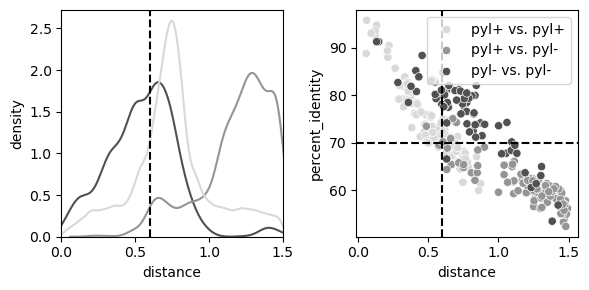

In [ ]:
fig, (ax_a, ax_b) = plt.subplots(figsize=(6, 3), ncols=2)

figure_df = list()
for row in distance_df[distance_df.distance < 1.5].itertuples():
    row_ = {'category':row.category}
    row_['distance'] = row.distance 
    row_['percent_identity'] = percent_identity_map.get((row.protein_id_1, row.protein_id_2))
    figure_df.append(row_)
figure_df = pd.DataFrame(figure_df)

sns.kdeplot(figure_df, hue='category', palette='Grays', x='distance', common_norm=False, ax=ax_a, legend=False)
ax_a.set_xlim(xmin=0, xmax=1.5)
ax_a.set_ylabel('density')
ax_a.axvline(0.6, ls='--', color='black')

sns.scatterplot(figure_df.groupby('category').apply(lambda x: x.sample(n=100, random_state=42), include_groups=False) , x='distance', y='percent_identity', hue='category', palette='Grays', ax=ax_b)
ax_b.legend().set_title('')
ax_b.axhline(70, ls='--', color='black')
ax_b.axvline(0.6, ls='--', color='black')

fig.tight_layout()
plt.show()

In [118]:
max_distance = 0.7
min_distance = 0.5
delta = 0.005

mask = distance_df.distance < max_distance
protein_ids = distance_df[mask].protein_id_1.tolist() + distance_df[mask].protein_id_2.tolist()
protein_ids = np.unique(protein_ids)

def sample(ref_distances, distance_df, delta=delta, n:int=5):
    sample_df = list()
    for distance in ref_distances:
        mask = (distance_df.distance < distance + delta) & (distance_df.distance > distance - delta)
        sample_df.append(distance_df[mask].sample(n, replace=False).copy())
    sample_df = pd.concat(sample_df)
    return sample_df 

ref_distances = distance_df[mask & (distance_df.category == 'pyl+ vs. pyl-')].distance.values 

sampled_distance_df = [distance_df[mask & (distance_df.category == 'pyl+ vs. pyl-')].copy()]
sampled_distance_df += [sample(ref_distances, distance_df[distance_df.category == 'pyl- vs. pyl-'])]
sampled_distance_df += [sample(ref_distances, distance_df[distance_df.category == 'pyl+ vs. pyl+'])]
sampled_distance_df = pd.concat(sampled_distance_df)
sampled_distance_df = sampled_distance_df.drop_duplicates(['genome_id_1', 'genome_id_2'])


In [112]:
def _annotate_residues(annotations:dict, ax=None, lines_only:bool=False):
    for seq, (start, stop) in annotations.items():
        positions = np.arange(start, stop)
        for x, aa in zip(positions, list(seq)):
            if not lines_only:
                ax.text(x, ax.get_ylim()[-1], aa, ha='center', va='bottom')
            ax.axvline(x, ls='--', lw=0.5, color='gray')

index, alignment = load_msa('../data/arf1_cleaned.afa', ids=protein_ids, conservation_threshold=0.8)
alignment_df = pd.DataFrame(alignment, index=index)

seq = ''.join(alignment[0])
domain_boundaries = get_domain_boundaries(seq)

get_domain_boundaries: NIKS boundaries 55-59.
get_domain_boundaries: YxCxxxF boundaries 119-126.
get_domain_boundaries: GTS boundaries 23-26.


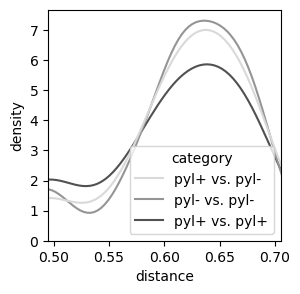

Num. pyl+ vs. pyl+ pairs in sample: 693
Num. pyl+ vs. pyl- pairs in sample: 282
Num. pyl- vs. pyl- pairs in sample: 1384


In [113]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.kdeplot(sampled_distance_df, hue='category', palette='Grays', x='distance', common_norm=False, ax=ax, legend=True)
ax.set_xlim(xmin=min_distance - delta, xmax=max_distance + delta)
ax.set_ylabel('density')
plt.show()

for category, df in sampled_distance_df.groupby('category'):
    print(f'Num. {category} pairs in sample:', len(df))

In [123]:
index, alignment = load_msa('../data/arf1_cleaned.afa', ids=protein_ids, conservation_threshold=0.8)
alignment_df = pd.DataFrame(alignment, index=index)
# alignment_df = alignment_df.replace(dayhoff)

figure_df = list()
for row in sampled_distance_df.itertuples():
    mismatch_positions = np.where(alignment_df.loc[row.protein_id_1].values != alignment_df.loc[row.protein_id_2].values)[0]
    for position in mismatch_positions:
        figure_df.append({'category':row.category, 'position':position})
figure_df = pd.DataFrame(figure_df)

genome_id_1
GCA_014361165.1    1524
GCA_021129915.1    1440
GCA_026016205.1    1419
GCF_000251105.1    1394
GCA_038850285.1    1387
                   ... 
GCA_002317795.1       1
GCA_019057635.1       1
GCA_035319575.1       1
GCA_028867435.1       1
GCA_029856635.1       1
Name: count, Length: 2398, dtype: int64

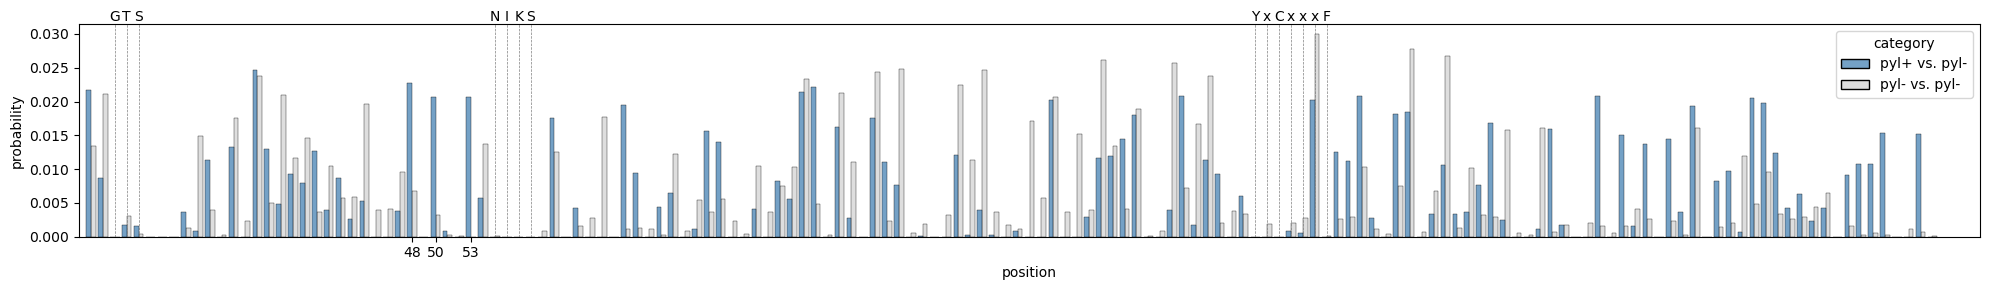

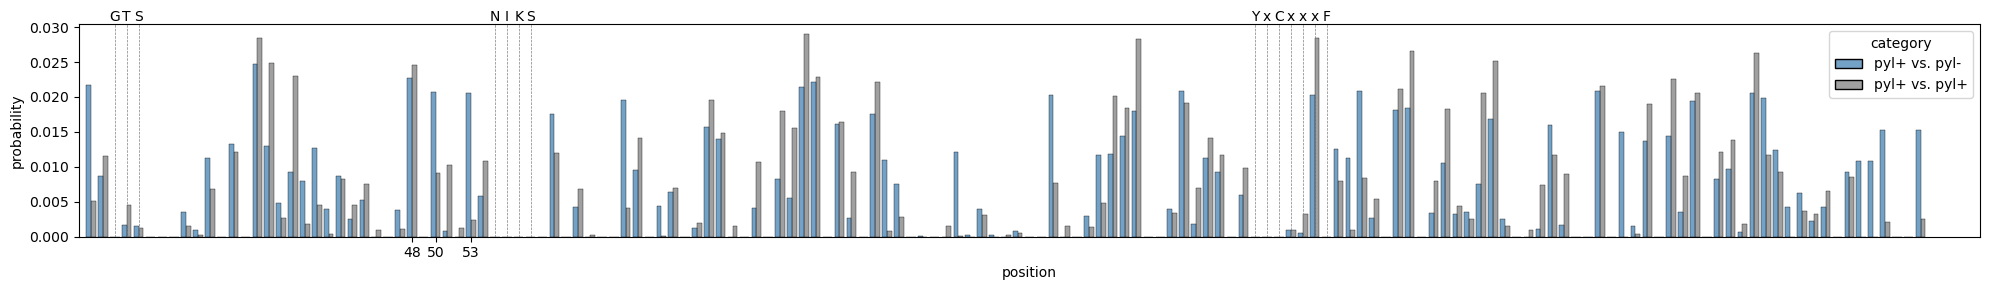

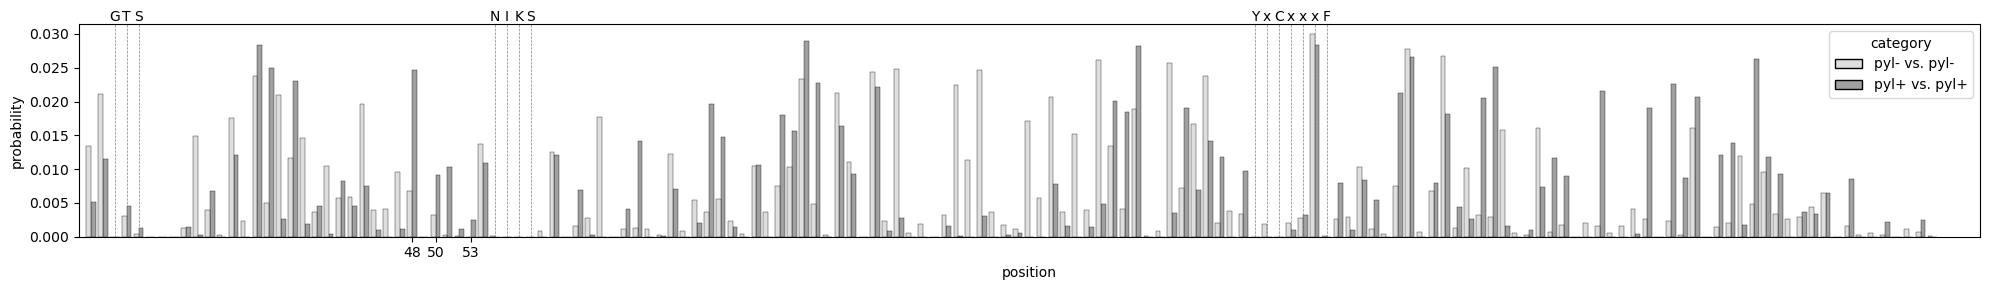

In [ ]:
# First pass: Compared organisms across all Archaea which are of comparable phylogenetic distance. Because being Pyl+ is localized to specific clades
# (largely monophyletic), the Pyl+ vs. Pyl- and Pyl- vs. Pyl+ comparisons were comparing Methanosarcinales and the other order, and nearly all 
# the Pyl- vs. Pyl- comparisons were amongst Halobacteriales.

# Initially observed that the mutation hotspots for Pyl+ vs. Pyl- are very similar to those
# for Pyl+ vs. Pyl+, suggesting that there may be noise related to the fact that where random mutations occur will have a phylogenetic signal, which
# might make something look significant which is not significant (i.e. comparing one sequence in an extremely redundant clade to lots of other sequences in that clade
# may result in increased signal for unimportant residues which randomly mutated in one of the sub-clades). I think that, because of the nature of the 
# distribution of Pyl+, it makes sense to only allow one comparison per genome, though this really limits the number of Pyl+ vs. Pyl- comparisons. 

# How to fix this problem? I want to use the Pyl- vs. Pyl- background signal from other organisms. In theory, mutations with residues amongst Pyl- organisms
# should not alter stop codon specificity, regardless of how far the evolutionary distance. There should be peaks around residues which have little bearing on 
# the enzyme function. Because of the chance of developing compensatory mutations at far evolutionary distances, it makes sense to limit the 
# maximum phylogenetic distance, i.e. look at the same order

def figure(min_position:int=30, max_position:int=55, categories=['pyl- vs. pyl-', 'pyl+ vs. pyl+'], annotate_residues:bool=False, stat:str='probability'):
    fig, ax = plt.subplots(figsize=(20, 3))

    mask = (figure_df.position < max_position) & (figure_df.position > min_position)
    mask = mask & figure_df.category.isin(categories)
    palette = {'pyl- vs. pyl-':'lightgray', 'pyl+ vs. pyl+':'gray', 'pyl+ vs. pyl-':'steelblue'}
    sns.histplot(figure_df[mask], x='position', discrete=True, hue='category', stat=stat, common_norm=False, palette=palette, multiple='dodge', shrink=0.8)
    ax.set_ylabel(stat)
    ax.set_xlim(xmin=min_position, xmax=max_position)

    if annotate_residues:
        _annotate_residues(domain_boundaries, ax=ax)

    ax.set_xticks([48, 50, 53])
        
    fig.tight_layout()
    plt.show()

c_domain = {'min_position':300, 'max_position':400}
n_domain = {'min_position':20, 'max_position':180}
m_domain = {'min_position':180, 'max_position':300}

figure(annotate_residues=True, categories=['pyl- vs. pyl-', 'pyl+ vs. pyl-'], **n_domain)
figure(annotate_residues=True, categories=['pyl+ vs. pyl+', 'pyl+ vs. pyl-'], **n_domain)
figure(annotate_residues=True, categories=['pyl+ vs. pyl+', 'pyl- vs. pyl-'], **n_domain)
# figure(exclude_pyl_plus=True, **m_domain)
# figure(exclude_pyl_plus=True, **c_domain)
# figure(min_position=90, max_position=130, exclude_pyl_plus=True)

In [131]:
# Is it possible to extend the divergence metric to pairwise comparisons somehow?
# A bit tricky because you would need to compare homogenous clades, and would be limited to Methanosarcinales and 
# Methanomassiliicoccales. 

# It seems bizarre to me that the mutation hotspots for the Pyl+ vs. Pyl+ comparisons are pretty much the same as for the Pyl+ and Pyl-. 
# This suggests that the location of the mutations is phylogenetically-correlated, i.e. Methanosarcinales aRF1s tend to differ from 
# one another at the same residues, regardless of whether or not something is Pyl+ or Pyl-. This fact is obscuring potential signals, I think. 

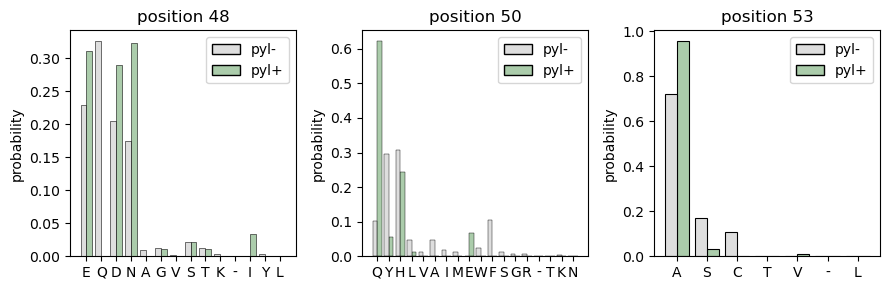

In [11]:
figure_df = alignment_df.copy()
figure_df['category'] = arf1_df.category 

palette = {'pyl+':'darkseagreen', 'pyl-':'lightgray'}
fig, axes = plt.subplots(ncols=3, figsize=(9, 3))
# plot_residue_counts(figure_df, position=30, ax=axes[0], hue='category', palette=palette)
# plot_residue_counts(figure_df, position=35, ax=axes[1], hue='category', palette=palette)
# plot_residue_counts(figure_df, position=40, ax=axes[2], hue='category', palette=palette)
plot_residue_counts(figure_df, position=48, ax=axes[0], hue='category', palette=palette)
plot_residue_counts(figure_df, position=50, ax=axes[1], hue='category', palette=palette)
plot_residue_counts(figure_df, position=53, ax=axes[2], hue='category', palette=palette)

fig.tight_layout()

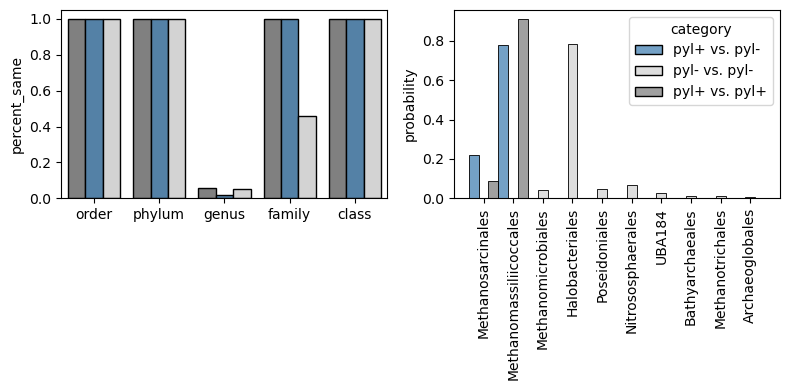

In [120]:
gtdb_metadata_df = gtdb_load_ar53_metadata()

levels = ['species', 'order', 'phylum', 'genus', 'species', 'family', 'class']

sampled_genome_ids = sampled_distance_df.genome_id_1.tolist() + sampled_distance_df.genome_id_2.tolist()
sampled_genome_ids = np.unique(sampled_genome_ids)

for level in levels:
    taxonomy_map = gtdb_metadata_df[level].to_dict()
    assert np.all(np.isin(sampled_genome_ids, list(taxonomy_map.keys()))), 'Some of the genome IDs do not have GTDB taxonomy.'
    sampled_distance_df[f'{level}_1'] = sampled_distance_df.genome_id_1.map(taxonomy_map)
    sampled_distance_df[f'{level}_2'] = sampled_distance_df.genome_id_2.map(taxonomy_map)
    # n_missing = (sampled_distance_df[f'{level}_1'] == 'none').sum() + (sampled_distance_df[f'{level}_2'] == 'none').sum()
    # print(f'Num. missing taxonomy assignments at level {level}:', n_missing)


fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(8, 4))

palette = {'pyl+ vs. pyl+':'gray', 'pyl- vs. pyl-':'lightgray', 'pyl+ vs. pyl-':'steelblue'}
figure_df = list()
for category, df in sampled_distance_df.groupby('category'):
    figure_df += [{'level':level, 'percent_same':(df[f'{level}_1'] == df[f'{level}_2']).sum() / len(df), 'category':category} for level in levels]
figure_df = pd.DataFrame(figure_df)
figure_df = figure_df[figure_df.level != 'species'].copy()

sns.barplot(figure_df, hue='category', x='level', y='percent_same', palette=palette, ax=ax_a, legend=False, edgecolor='black', width=0.8)
ax_a.set_xlabel('')

figure_df = list()
for level in levels:
    figure_df += [{'category':row.category, 'level':level, 'taxon':getattr(row, f'{level}_1')} for row in sampled_distance_df.itertuples()]
    figure_df += [{'category':row.category, 'level':level, 'taxon':getattr(row, f'{level}_2')} for row in sampled_distance_df.itertuples()]
figure_df = pd.DataFrame(figure_df)

stat = 'probability'

figure_df = figure_df[figure_df.level == 'order'].copy()
taxa = figure_df.taxon.value_counts(sort=True).iloc[:10].index.tolist()
figure_df = figure_df[figure_df.taxon.isin(taxa)].copy()
                      
sns.histplot(figure_df, x='taxon', hue='category', ax=ax_b, palette=palette, multiple='dodge', stat=stat, common_norm=False, edgecolor='black')
ax_b.set_xticks(ax_b.get_xticks(), labels=ax_b.get_xticklabels(), rotation=90)
ax_b.set_xlabel('')
ax_b.set_ylabel(stat)
# ax_b.set_xlim(xmin=0, xmax=10)

fig.tight_layout()
plt.show()

In [121]:
sampled_distance_df[sampled_distance_df.order_1 == 'Methanomassiliicoccales'].category.value_counts()
arf1_df[arf1_df.order == 'Methanosarcinales'].category.value_counts()

category
pyl+    24
pyl-    23
Name: count, dtype: int64

In [ ]:
# Why are the only Pyl+ vs. Pyl- comparisons within Methanosarcinales?

methanomassiliicoccales_genome_ids = arf1_df[arf1_df.order == 'Methanomassiliicoccales'].genome_id.values 
figure_df = sampled_distance_df[sampled_distance_df.genome_id_1.isin(methanomassiliicoccales_genome_ids) | sampled_distance_df.genome_id_2.isin(methanomassiliicoccales_genome_ids)].copy()
figure_df = figure_df[(figure_df.distance > min_distance) & (figure_df.distance < max_distance)].copy()
figure_df = figure_df[figure_df.category == 'pyl+ vs. pyl-'].copy()

# sns.ecdfplot(figure_df, x='distance', hue='category')
figure_df[figure_df.category == ]

,genome_id_1,genome_id_2,distance,category_1,category_2,protein_id_1,protein_id_2,category,species_1,species_2,order_1,order_2,phylum_1,phylum_2,genus_1,genus_2,family_1,family_2,class_1,class_2
485701,GCA_012520845.1,GCA_944321505.1,0.59042,pyl+,pyl-,JAAYNL010000015.1_197,CALULN010000004.1_21,pyl+ vs. pyl-,JAAYNL01 sp012520845,SIG5 sp944321505,Methanomassiliicoccales,Methanomassiliicoccales,Thermoplasmatota,Thermoplasmatota,JAAYNL01,SIG5,Methanomethylophilaceae,Methanomethylophilaceae,Thermoplasmata,Thermoplasmata
485720,GCA_012520845.1,GCA_016297775.1,0.66169,pyl+,pyl-,JAAYNL010000015.1_197,JAEDGA010000019.1_11,pyl+ vs. pyl-,JAAYNL01 sp012520845,SIG5 sp016297775,Methanomassiliicoccales,Methanomassiliicoccales,Thermoplasmatota,Thermoplasmatota,JAAYNL01,SIG5,Methanomethylophilaceae,Methanomethylophilaceae,Thermoplasmata,Thermoplasmata
485743,GCA_012520845.1,GCA_017455785.1,0.59160,pyl+,pyl-,JAAYNL010000015.1_197,JAFSYZ010000222.1_2,pyl+ vs. pyl-,JAAYNL01 sp012520845,Methanarcanum sp017455785,Methanomassiliicoccales,Methanomassiliicoccales,Thermoplasmatota,Thermoplasmatota,JAAYNL01,Methanarcanum,Methanomethylophilaceae,Methanomethylophilaceae,Thermoplasmata,Thermoplasmata
503909,GCA_029982165.1,GCA_012515075.1,0.69646,pyl-,pyl+,JARRCN010000001.1_490,JAAYZC010000025.1_10,pyl+ vs. pyl-,UBA9915 sp9915u,JAAYZC01 sp012515075,Methanomassiliicoccales,Methanomassiliicoccales,Thermoplasmatota,Thermoplasmatota,UBA9915,JAAYZC01,Methanomethylophilaceae,Methanomethylophilaceae,Thermoplasmata,Thermoplasmata
504353,GCA_029982165.1,GCA_031285205.1,0.66896,pyl-,pyl+,JARRCN010000001.1_490,JAITWO010000030.1_13,pyl+ vs. pyl-,UBA9915 sp9915u,Methanomicula sp031285205,Methanomassiliicoccales,Methanomassiliicoccales,Thermoplasmatota,Thermoplasmatota,UBA9915,Methanomicula,Methanomethylophilaceae,Methanomethylophilaceae,Thermoplasmata,Thermoplasmata
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729594,GCA_012522645.1,GCA_034006405.1,0.62252,pyl-,pyl+,JAAYKC010000015.1_31,JAVESW010000010.1_18,pyl+ vs. pyl-,RumEn-M2 sp012522645,JALNYB01 sp023230065,Methanomassiliicoccales,Methanomassiliicoccales,Thermoplasmatota,Thermoplasmatota,RumEn-M2,JALNYB01,Methanomethylophilaceae,Methanomethylophilaceae,Thermoplasmata,Thermoplasmata
729597,GCA_012522645.1,GCA_034928305.1,0.67633,pyl-,pyl+,JAAYKC010000015.1_31,JAYFOZ010000001.1_161,pyl+ vs. pyl-,RumEn-M2 sp012522645,VadinCA11 sp034928305,Methanomassiliicoccales,Methanomassiliicoccales,Thermoplasmatota,Thermoplasmatota,RumEn-M2,VadinCA11,Methanomethylophilaceae,Methanomethylophilaceae,Thermoplasmata,Thermoplasmata
729600,GCA_012522645.1,GCA_002497195.1,0.69918,pyl-,pyl+,JAAYKC010000015.1_31,DAMX01000056.1_4,pyl+ vs. pyl-,RumEn-M2 sp012522645,VadinCA11 sp002497195,Methanomassiliicoccales,Methanomassiliicoccales,Thermoplasmatota,Thermoplasmatota,RumEn-M2,VadinCA11,Methanomethylophilaceae,Methanomethylophilaceae,Thermoplasmata,Thermoplasmata
729601,GCA_012522645.1,GCA_002505345.1,0.68358,pyl-,pyl+,JAAYKC010000015.1_31,DAUY01000014.1_20,pyl+ vs. pyl-,RumEn-M2 sp012522645,VadinCA11 sp002505345,Methanomassiliicoccales,Methanomassiliicoccales,Thermoplasmatota,Thermoplasmatota,RumEn-M2,VadinCA11,Methanomethylophilaceae,Methanomethylophilaceae,Thermoplasmata,Thermoplasmata
